### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
from fastai import *
from fastai.text import *

In [4]:
from ulmfit.pretrain_lm import *

In [5]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

###  Train LM from Wiki

In [5]:
exp = LMHyperParams(dataset_path='data/wiki/ru-100/', qrnn=False, tokenizer='v',
                    lang='ru', name='russian')

Max vocab: 60000
Cache dir: data/wiki/ru-100/models/v60k
Model dir: data/wiki/ru-100/models/v60k/lstm_russian.m


In [6]:
data_lm = exp.load_wiki_data(bs=20)

Tokenized data loaded
Size of vocabulary: 60007
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', 'в', '.', 'и', '(', ')', 'на', '—', '»', '«', 'с', 'года']


In [7]:
data_lm.train_dl.batch_size

20

In [8]:
len(data_lm.train_dl)

66131

In [9]:
data_lm.show_batch()

idx,text
0,"xxbos \n= Теория Маркуса xxunk xxunk конце 50-х — начале 60-х годов XX века Р. Маркус предложил теорию , xxunk перенос электрона в xxunk xxunk в рамках xxunk приближения . Затем теория Маркуса , известная также как теория переходного состояния ( ) , xxunk на xxunk процессы xxunk вклад Маркуса заключался в xxunk влияния растворителя на перенос электрона . Он рассмотрел движение электрона по поверхности потенциальной энергии , координатами которой"
1,"его подготовку к xxunk в марафоне « Париж — Дакар » 1978 года . Две xxunk xxunk . xxunk « xxunk » оказались в числе трети xxunk участников , благополучно xxunk в этом соревновании . В 1981 году французская команда , выступавшая на этих автомобилях , сумела занять третье место , а в сезоне 1982 года — второе . В дальнейшем французским xxunk неоднократно удавалось занимать призовые места на xxunk"
2,", никогда не живших даже близко к Москве .\n\nПоявление и становление Москвы .\nРека Москва представляла собой xxunk звено между важными торговыми путями . Её верхнее течение почти xxunk к северной части xxunk торгового пути , xxunk далее через озеро xxunk и Великий Новгород ( либо через Западную Двину и Полоцк ) в Балтику . С верхней Волги вниз по Днепру через Смоленск и Киев можно было попасть в Чёрное море"
3,"среднее учтено в xxunk , которая обязательно присутствует в числе факторов , а возможная xxunk xxunk учитывается за счет соответствующего xxunk всех коэффициентов b .\n\nКак и в общем случае модели xxunk выбора в основе модели лежит предположение о наличии некоторой скрытой ( не xxunk ) переменной formula _ 12 , в зависимости от значений которой xxunk переменная formula _ 2 принимает значение formula _ 4 или formula _ 3 xxunk"
4,"xxunk на территории современных Европы , Северной Америки и Центральной Азии , в xxunk периоде в Австралии и Антарктиде . В России обнаружены в верхнем xxunk Амурской области .\n\nСистематика .\nКлассификация .\nПо данным сайта xxunk , на сентябрь 2017 года в xxunk включают следующие таксоны xxunk больше десятка родов включают в xxunk в статусе "" xxunk xxunk "" : xxunk xxunk представлена Ричардом xxunk и его коллегами в 2011 году :\n\n\n"


In [10]:
learn = exp.create_lm_learner(data_lm=data_lm)

Training args:  {'tie_weights': True, 'clip': 0.12, 'bptt': 70, 'pretrained_fnames': None, 'pretrained_model': None} dps:  [0.25 0.1  0.2  0.02 0.15]


In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


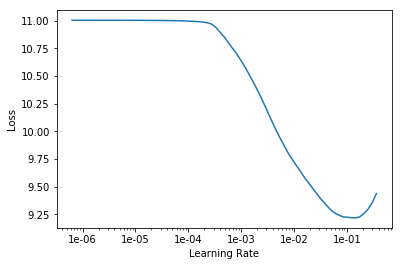

In [15]:
learn.recorder.plot(skip_end=15)

In [13]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.790559,4.490133,0.323604
2,4.864450,4.500994,0.319487
3,4.748384,4.529564,0.316132
4,4.849702,4.508623,0.316207
5,4.770301,4.496254,0.319752
6,4.720208,4.406010,0.327390
7,4.711561,4.319860,0.332331
8,4.501110,4.232864,0.340277
9,4.592453,4.178996,0.348836
10,4.533059,4.158452,0.351359


In [17]:
learn.save("lm_10i")

In [18]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.472561,4.172580,0.347433
2,4.535592,4.231564,0.345258
3,4.665092,4.226340,0.340519
4,4.571750,4.222316,0.344372
5,4.577867,4.177708,0.344268
6,4.619215,4.155945,0.351058
7,4.584020,4.134072,0.352429
8,4.325761,4.128910,0.353810
9,4.486596,4.115236,0.356344
10,4.508442,4.109302,0.357113


In [19]:
learn.save("lm_20i")

### Fine tune on ruSentEval 

In [7]:
rusent_data_path = Path('data/ruSentEval/')

In [8]:
rusent_data_path.ls()

[PosixPath('data/ruSentEval/texts.csv'),
 PosixPath('data/ruSentEval/models'),
 PosixPath('data/ruSentEval/negative.csv'),
 PosixPath('data/ruSentEval/positive.csv')]

In [12]:
moses_tok_args = dict(tokenizer=Tokenizer(
    tok_func=BaseTokenizer, lang='ru', pre_rules=[replace_std_toks], post_rules=[]))

In [13]:
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'texts.csv', bs=20, **moses_tok_args)

In [14]:
data1_lm.batch_size

20

In [15]:
data1_lm.device

device(type='cuda')

In [16]:
data1_lm.show_batch()

idx,text
0,xxbos Плохо xxunk хотели скорую вызывать xxunk ужасно болит ;(;( xxbos Я сейчас xxunk Уже 2 часа сижу над музыкой и не могу её ни xxunk xxunk АД xxunk Ну абсолютно ничего не получается xxbos xxunk он у тебя как xxunk xxunk в окошко) xxbos голова xxunk потому что я спала xxunk да? xxbos А где xxunk метро xxunk магазине не xxunk xxunk улицах почти xxunk я снова попала в
1,"xxunk xxbos @olegkarev2 @IrinaSklyar42 @gre_tania @ITARTASS_news Вы просто столько сразу xxunk xxbos я тоже этим xxunk чувак, у тебя ничего не выйдет, так что забудь :DD xxunk xxbos Олег пришел чинить xxunk крутой xxunk детство вспомнила xxbos Я очень долго xxunk когда xxunk поменял имя, а тут... xxunk xxbos Я одна, но мне не страшно :D Даже весело!:) А когда будет холодно я одену xxunk xxbos xxunk мне голоса xxunk"
2,школу пойду:( xxbos RT xxunk А вот собственно xxunk и его xxunk которых мы здесь) @ xxunk xxunk xxunk xxbos зависть людей xxunk же это смешно и xxunk же не xxunk другие стараются и цели xxunk бы пример у них xxunk xxbos @SFGO76 @kononenkome xxunk Так и xxunk xxunk xxunk не xxunk о своих xxunk xxbos RT xxunk xxunk Лето xxunk Падалеки xxunk xxunk xxunk xxunk xxunk xxunk xxbos RT
3,"xxbos Иногда когда хочешь быть любимой и xxunk приходится xxunk xxunk xxbos только 2 xxunk такое чувство что уже число xxunk xxbos RT xxunk xxunk xxunk все ясно с ним, xxunk пусть одеть не xxunk а то xxunk xxunk xxbos xxunk я знаю всю эту историю с xxunk и это не мешает мне слушать и наслаждаться их xxunk и тем более ничего xxunk здесь нет xxbos Все нормальные люди"
4,"что только xxunk xxunk @sazam xxbos По русскому сказали описать свой учебный день. xxunk xxunk xxunk xxbos xxunk xxunk даже представить боюсь( xxbos xxunk @Djulia_Puts блиин , а я так и не увидела сказки :( xxbos xxunk У нас в компании нет xxunk :( xxbos xxunk локальный филиал xxunk :) Тогда мы идём к вам))) xxbos xxunk эх, понимаю :( у меня не очень, ибо уроков много делать надо. Отдохни"


In [17]:
pretrained_fnames = ['lm_20i', 'itos']

In [18]:
learn = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.3)

Unknown tokens 45908, first 100: ['RT', '', ':(', ':)', ':D', ';)', ':-)', '((', '))', '(((', ')))', ';(', ':-(', 'спасибо', 'НЕ', ':((', 'да,', '=)', '=(', 'Хочу', 'блин', 'о_О', ':*', 'нет,', 'то,', ':3', 'знаю,', 'сижу', ':))', 'прям', 'пойду', 'щас', 'болит', 'скучаю', 'блин,', ':(((', 'с:', 'х)', ':|', ':DD', 'того,', '#RT', 'так,', 'Доброе', 'смотрю', '^_^', ':)))', 'вк', 'жаль', 'жду', '#євромайдан', 'ахах', 'ахаха', 'нг', 'хорошо,', 'НГ', '((((', '%)', 'давай', 'Блин,', 'Вчера', 'аж', 'твит', 'жалко', 'кажется,', 'нибудь', '"', 'бля', 'боюсь', 'МЕНЯ', 'ТЫ', 'нет(', 'ЧТО', 'Люблю', 'меня,', 'ненавижу', 'Опять', 'НА', 'твиттер', ':-D', 'пиздец', 'лень', 'Блин', 'что,', 'том,', 'фотки', ':-/', 'я,', 'блять', '))))', 'день,', 'все,', 'забыла', 'Сижу', 'иду', 'конечно,', 'нет.', 'знаешь', 'нету', 'смогу']


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


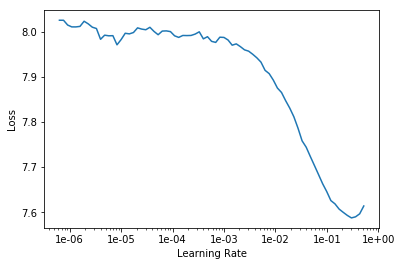

In [20]:
learn.recorder.plot(skip_end=15)

In [21]:
moms = (0.8, 0.7)

In [22]:
learn.fit_one_cycle(1, 1e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,5.595322,5.233947,0.291232


In [23]:
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60007, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60007, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60007, bias=True)
    (output_dp): RNNDropout()
  )
)

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,5.219792,5.100799,0.299793
2,5.142128,5.004897,0.307976
3,5.020510,4.925118,0.315033
4,4.917074,4.867299,0.320569
5,4.751203,4.832978,0.323905
6,4.586401,4.820917,0.325238
7,4.459358,4.818737,0.326496
8,4.336007,4.827503,0.326354
9,4.227273,4.839336,0.326179
10,4.179836,4.847776,0.325249


In [26]:
learn.save('fine_tuned')

In [27]:
learn.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.225437,4.846021,0.325338
2,4.375489,4.842775,0.325114
3,4.415745,4.848830,0.324562
4,4.353135,4.844534,0.325799
5,4.231872,4.870059,0.324365
6,4.094308,4.882177,0.324524
7,3.961023,4.921151,0.324092
8,3.811466,4.946047,0.322440
9,3.689302,4.978610,0.320146
10,3.637908,4.989728,0.319697


In [28]:
learn.save('fine_tuned_20')